In [21]:
import numpy as np , math
from skimage import io
from CarDetection_HOG import display , get_hist_grid , Block_Normalization
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from skimage.transform import resize
n_imgs = 16000
n_win = 32
n_cell = 8
n_block = 2
n_sml_hist = 18
hists_per_dim =(n_win-n_cell*n_block)//n_cell+1 
n_hist = hists_per_dim * hists_per_dim*n_sml_hist*n_block*n_block
test_ratio = 0.2
thres = 20

In [12]:
x = np.zeros((n_imgs,n_hist) , dtype=np.float)
y = np.zeros((n_imgs) , dtype=np.float)

img_index = 1
#Reading Vehicles & Non-Vehicles images:
for i in range(0 , n_imgs//2 , 2):
    img = io.imread("data\\Vehicles\\"+ "v_ (" + str(img_index) + ").png")
    img = resize(img, (n_win, n_win), anti_aliasing=True)
    x[i,:] = Block_Normalization(get_hist_grid(img , n_cell))
    y[i] = 1.0
    
    img = io.imread("data\\Non-Vehicles\\"+ "nv_ (" + str(img_index) + ").png")
    img = resize(img, (n_win, n_win), anti_aliasing=True)
    x[i+1,:] = Block_Normalization(get_hist_grid(img , n_cell))
    y[i+1] = 0.0
    
    img_index += 1

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = test_ratio)
clf = SVC(kernel='linear')
clf.fit(x_train , y_train)
p = clf.predict(x_test)
print('Prediction ', p)
print('Accuracy ' , accuracy_score(y_test , p))

Prediction  [1. 0. 0. ... 0. 1. 0.]
Accuracy  0.975625


In [14]:
def Classify(img):
    res = clf.predict(img)
    return res[0]

In [15]:
def Crop_Image(img):
    return img[img.shape[0]//2 : img.shape[0]]

In [16]:
def Slide_Window(img , window_size , step):
    h = (img.shape[0] - window_size) // step + 1
    w = (img.shape[1] - window_size) // step + 1
    
    R,C = img.shape[0] , img.shape[1]
    mat = np.zeros((h,w) , dtype = np.byte)
    window = np.zeros((1,n_hist) , dtype=np.float)
    i = -1
    
    for I in range(0 , R , step):
        if(R-I >= window_size):
            i += 1
            j = 0
            for J in range(0 , C , step):
                if(C-J >= window_size):
                    window[0,:] = Block_Normalization(get_hist_grid(img[I : I+window_size , J : J+window_size] , n_cell))
                    mat[i][j] = Classify(window)
                    
                    j += 1
        
                else:
                    break
        else:
            break
                              
    return mat

In [17]:
def get_heatmap(img, win_r, win_c, scale1, scale2):
    img = Crop_Image(img)
    img = resize(img, (scale1, scale2), anti_aliasing=True)
    r, c = img.shape[0], img.shape[1]
    win_mat=Slide_Window(img, win_r, 1)
    print(win_mat.shape)
    print(win_mat)
    for i in range(r-win_r+1):
        for j in range(1, c-win_c+1):
            win_mat[i,j]+=win_mat[i,j-1]
    for j in range(c-win_c+1):
        for i in range(1, r-win_r+1):
            win_mat[i,j]+=win_mat[i-1,j]
    pxl_mat = np.zeros((r, c), dtype=int)
    for i in range(r):
        for j in range(c):
            tl_i, tl_j = max(i-win_r+1, 0), max(j-win_c+1, 0)
            br_i, br_j = min(i+win_r-1, r-1), min(j+win_c-1, c-1)
            br_i, br_j = br_i-win_r+1, br_j-win_c+1
            sum = win_mat[br_i, br_j]
            if(tl_i-1>=0):
                sum -= win_mat[tl_i-1, br_j]
            if(tl_j-1>=0):
                sum -= win_mat[br_i, tl_j-1]
            if(tl_i-1>=0 and tl_j-1>=0):
                sum += win_mat[tl_i-1, tl_j-1]
            if(sum < thres):
                sum = 0
            pxl_mat[i, j] = sum
    return pxl_mat

In [27]:
im = io.imread('x.jpeg')
qt = get_heatmap(im , n_win, n_win, 64, 128)
#print(qt)

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(33, 97)
[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


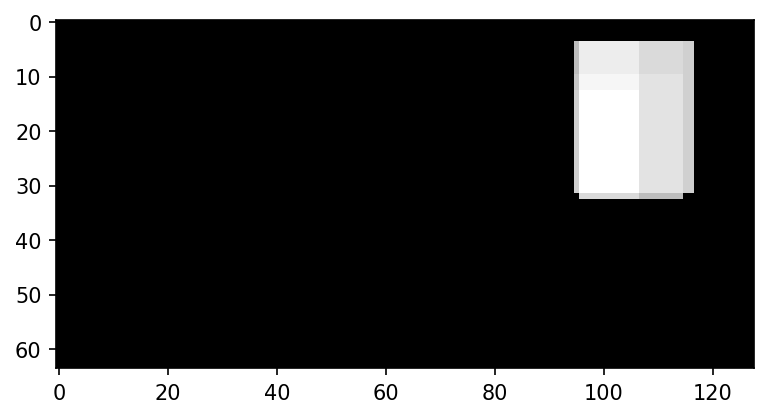

In [28]:
display(qt, True)

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


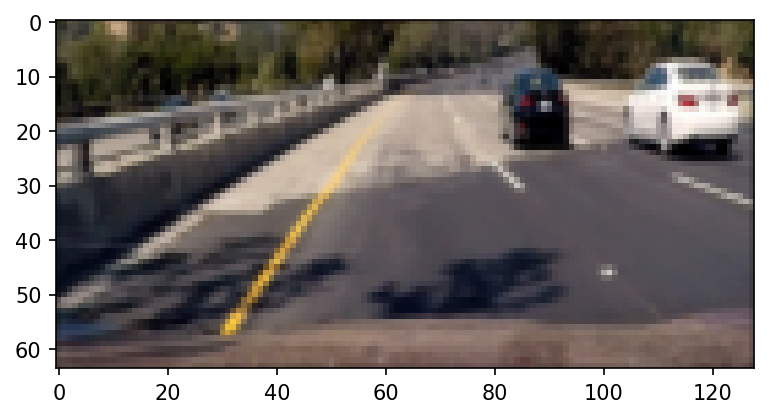

In [29]:
img2 = Crop_Image(im)
img2 = resize(img2, (64, 128), anti_aliasing=True)
display(img2, False)